In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.amp import autocast, GradScaler
from trainning.fusion_dataset import FusionDataset
import numpy as np
import matplotlib.pyplot as plt

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DPMSolverMultistepScheduler

class CNNBranch(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, feature_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class TransformerBranch(nn.Module):
    def __init__(self, feature_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)  # [B,HW,C]
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        return x


class HybridEncoder(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.feature_dim = feature_dim
        self.cnn1 = CNNBranch(in_channels, feature_dim)
        self.cnn2 = CNNBranch(in_channels, feature_dim)
        self.transformer = TransformerBranch(feature_dim=feature_dim)

    def forward(self, img1, img2):
        feat1 = self.cnn1(img1)
        feat2 = self.cnn2(img2)
        fused = (feat1 + feat2) / 2
        global_context = self.transformer(fused)
        return global_context  # [B, feat_dim, H', W']


class FusionSDTurboModel(nn.Module):
    def __init__(self, encoder: nn.Module,
                 pretrained_model="stabilityai/sd-turbo",
                 device="cuda"):
        super().__init__()
        self.encoder = encoder

        # Load pretrained SD-Turbo components
        self.vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae").to(device)
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet").to(device)

        # Enable gradient checkpointing for UNet
        self.unet.enable_gradient_checkpointing()

        # Recommended SD scheduler
        self.scheduler = DPMSolverMultistepScheduler.from_pretrained(pretrained_model, subfolder="scheduler")

        # Cross-attention projection
        cross_dim = self.unet.config.cross_attention_dim
        self.proj = nn.Linear(encoder.feature_dim, cross_dim)

        # Resize inputs to 256x256
        self.upsample = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC)

        # Latent scaling factor
        self.latent_scale = self.vae.config.scaling_factor

        self.device = device

    def encode_latents(self, x):
        latents = self.vae.encode(x).latent_dist.sample()
        return latents * self.latent_scale

    def decode_latents(self, latents):
        latents = latents / self.latent_scale
        imgs = self.vae.decode(latents).sample
        return imgs

    def forward(self, img1, img2, target, timesteps):
        # Upsample to 256x256
        img1 = self.upsample(img1)
        img2 = self.upsample(img2)
        target = self.upsample(target)

        # Mixed precision context
        with torch.amp.autocast(self.device):
            # Encode & fuse
            fused_feats = self.encoder(img1, img2)
            pooled = fused_feats.mean(dim=[2, 3])        # [B, feat_dim]
            cond = self.proj(pooled).unsqueeze(1)        # [B,1,cross_dim]

            # Encode target to latent
            latents = self.encode_latents(target)

            # Add noise
            noise = torch.randn_like(latents)
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

            # Predict noise
            noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states=cond).sample

        return noise_pred, noise, latents

In [ ]:
def freeze_module(module):
    """Utility: Freeze all params in a module"""
    for p in module.parameters():
        p.requires_grad = False


def train(model, dataloader, device="cuda", epochs=10, lr=2e-5):
    model.to(device)

    # Freeze VAE + UNet
    freeze_module(model.vae)
    freeze_module(model.unet)

    # Optimizer → only train encoder + projection
    opt = torch.optim.AdamW(list(model.encoder.parameters()) + list(model.proj.parameters()), lr=lr)
    scaler = GradScaler(device) 

    for epoch in range(epochs):
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for img1, img2, target in pbar:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)

            bsz = img1.size(0)
            timesteps = torch.randint(
                0, model.scheduler.num_train_timesteps, (bsz,), device=device, dtype=torch.long
            )

            # Mixed precision forward
            with autocast(device):
                noise_pred, noise, latents = model(img1, img2, target, timesteps)
                loss = F.mse_loss(noise_pred, noise)

            # Backward + optimizer step
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            pbar.set_postfix({"loss": loss.item()})

In [2]:
def show_test_results(model, dataloader, device="cuda", num_images=5, num_inference_steps=50):
    model.eval()
    model.to(device)

    img1, img2, target = next(iter(dataloader))
    img1, img2, target = img1[:num_images], img2[:num_images], target[:num_images]
    img1, img2, target = img1.to(device), img2.to(device), target.to(device)

    bsz = img1.size(0)

    with torch.no_grad():
        # --- Conditioning ---
        fused_feats = model.encoder(img1, img2)
        pooled = fused_feats.mean(dim=[2, 3])                # [B, feat_dim]
        cond = model.proj(pooled).unsqueeze(1)               # [B,1,cross_dim]

        # --- Random latent init ---
        latent_shape = (bsz, model.unet.in_channels, 32, 32) # 256x256 → 32x32
        latents = torch.randn(latent_shape, device=device)

        # --- Denoising loop ---
        scheduler = model.scheduler
        scheduler.set_timesteps(num_inference_steps, device=device)
        for t in scheduler.timesteps:
            noise_pred = model.unet(latents, t, encoder_hidden_states=cond).sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        # --- Decode latents ---
        pred_imgs = model.decode_latents(latents)


    # Simple denormalization from [-1, 1] → [0, 1]
    def denorm(x):
        return (x.clamp(-1, 1) + 1) / 2

    # Display input, target, and prediction
    for i in range(min(num_images, bsz)):
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        axes[0].imshow(denorm(img1[i]).permute(1, 2, 0).cpu())
        axes[0].set_title("Input 1")
        axes[1].imshow(denorm(img2[i]).permute(1, 2, 0).cpu())
        axes[1].set_title("Input 2")
        axes[2].imshow(denorm(target[i]).permute(1, 2, 0).cpu())
        axes[2].set_title("Target")
        axes[3].imshow(denorm(pred_imgs[i]).permute(1, 2, 0).cpu())
        axes[3].set_title("Generated")
        for ax in axes:
            ax.axis("off")
        plt.show()

In [3]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

base_dataset = datasets.ImageFolder(root="data/afhq/train", transform=None)

# Use a subset for quick testing
subset_indices = np.random.choice(len(base_dataset), 1000, replace=False)
small_dataset = Subset(base_dataset, subset_indices)

fusion_dataset = FusionDataset(small_dataset, modality="pair", transform=transform)
fusion_loader = DataLoader(fusion_dataset, batch_size=8, shuffle=True, num_workers=6, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# instantiate encoder and pipeline model
encoder = HybridEncoder(in_channels=3, feature_dim=128)
model = FusionSDTurboModel(encoder=encoder, pretrained_model="stabilityai/sd-turbo", device=device)

Using device: cuda


In [5]:
train(model, dataloader=fusion_loader, device=device, epochs=10, lr=2e-5)

Start training...


Epoch 1/10:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DPMSolverMultistepScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DPMSolverMultistepScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 10/10: 100%|██████████| 125/125 [05:54<00:00,  2.83s/it, loss=0.283]


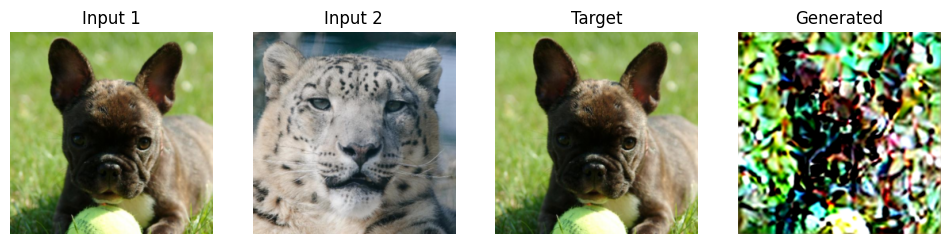

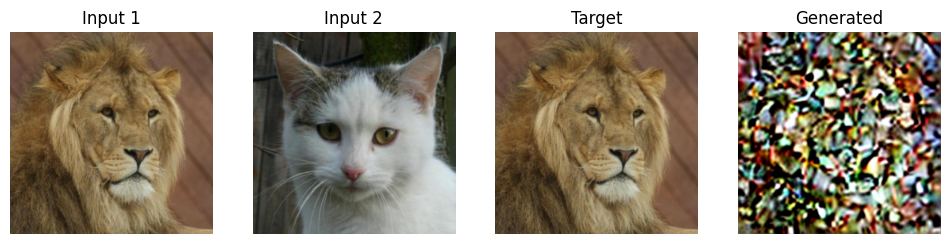

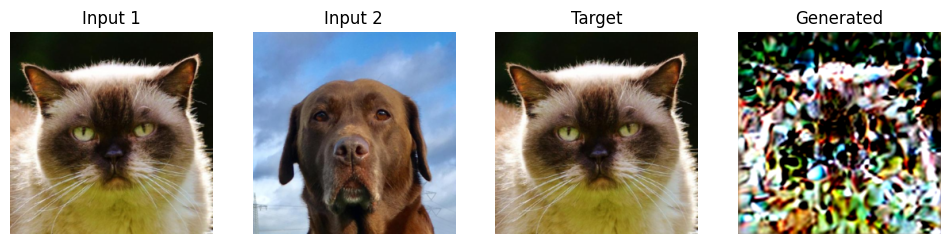

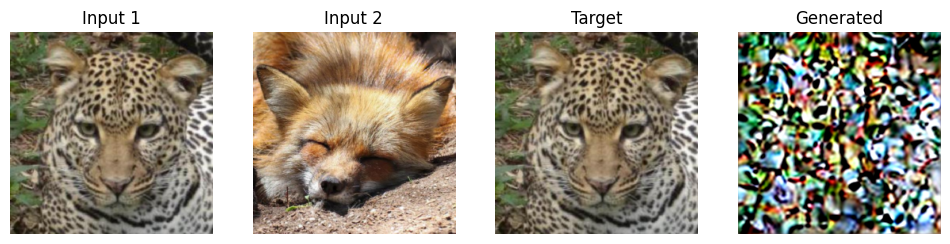

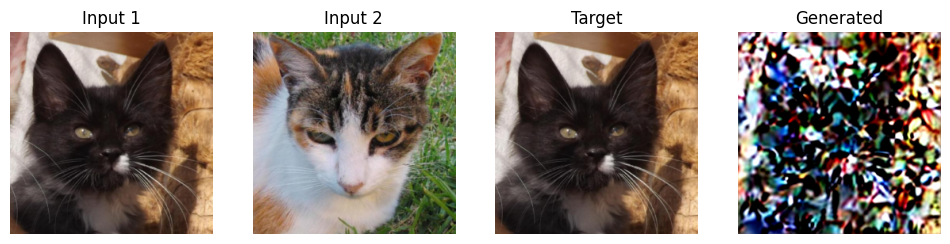

In [10]:
show_test_results(model, fusion_loader, device=device, num_images=5, timestep=1200)

Files already downloaded and verified


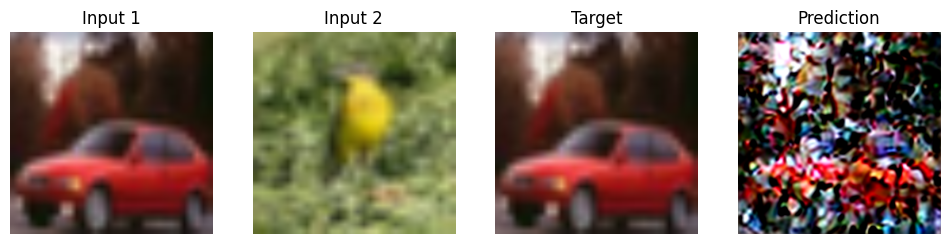

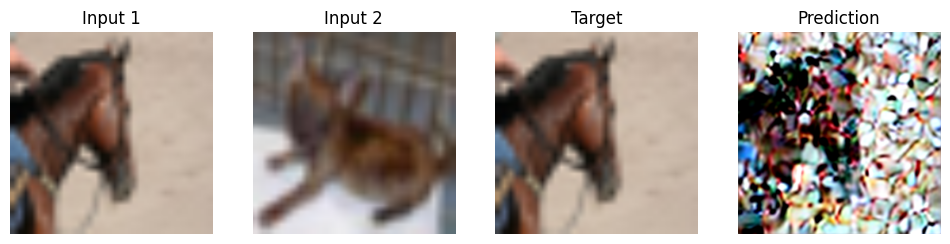

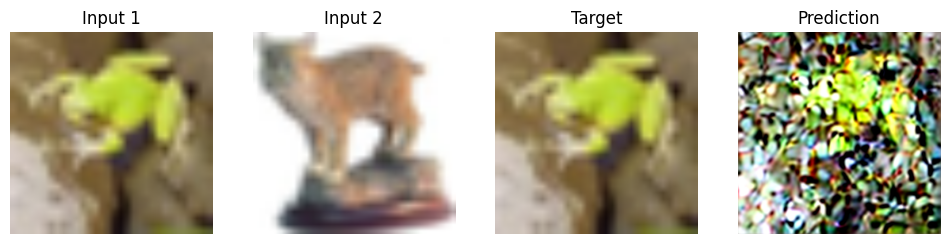

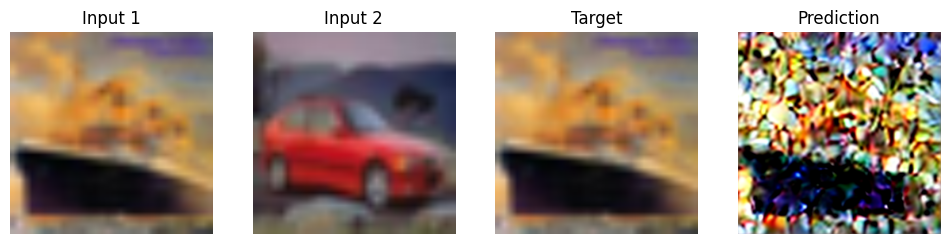

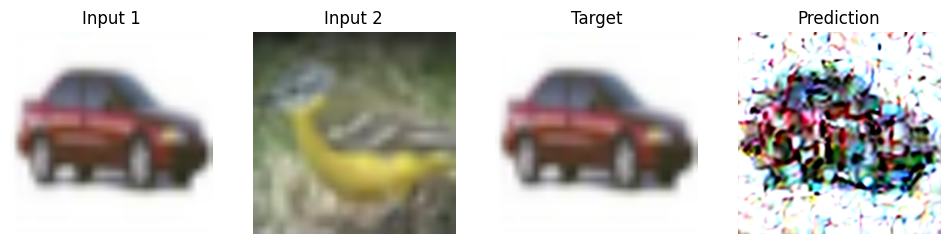

In [ ]:
# Cifar10 (32x32 images)
show_test_results(model, fusion_loader, device=device, num_images=5, timestep=1000)